In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd


Load and Process Data

In [10]:
data = pd.read_csv('../Data/fer2013.csv')

# Preprocess data
X = np.array([np.fromstring(pixel_str, sep=' ').reshape(48, 48) for pixel_str in data['pixels']])
y = data['emotion'].values

print(X)
print(y)

[[[ 70.  80.  82. ...  52.  43.  41.]
  [ 65.  61.  58. ...  56.  52.  44.]
  [ 50.  43.  54. ...  49.  56.  47.]
  ...
  [ 91.  65.  42. ...  72.  56.  43.]
  [ 77.  82.  79. ... 105.  70.  46.]
  [ 77.  72.  84. ... 106. 109.  82.]]

 [[151. 150. 147. ... 129. 140. 120.]
  [151. 149. 149. ... 122. 141. 137.]
  [151. 151. 156. ... 109. 123. 146.]
  ...
  [188. 188. 121. ... 185. 185. 186.]
  [188. 187. 196. ... 186. 182. 187.]
  [186. 184. 185. ... 193. 183. 184.]]

 [[231. 212. 156. ...  44.  27.  16.]
  [229. 175. 148. ...  27.  35.  27.]
  [214. 156. 157. ...  28.  22.  28.]
  ...
  [241. 245. 250. ...  57. 101. 146.]
  [246. 250. 252. ...  78. 105. 162.]
  [250. 251. 250. ...  88. 110. 152.]]

 ...

 [[ 17.  17.  16. ...  83. 114. 245.]
  [ 18.  17.  16. ... 104. 136. 253.]
  [ 19.  16.  17. ... 128. 152. 255.]
  ...
  [  4.  21.  46. ... 186. 180. 187.]
  [  5.  17.  41. ... 177. 172. 176.]
  [ 20.  15.  22. ... 154. 133. 113.]]

 [[ 30.  28.  28. ...  60.  50.  44.]
  [ 30.  27.

Normalize pixel data

In [11]:
# Normalize pixel values
X = X / 255.0

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y = torch.tensor(y, dtype=torch.long)

Split into train and test sets

In [12]:
train_size = int(0.8 * len(X))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]


Create Data Loader

In [13]:
train_loader = DataLoader(list(zip(train_X, train_y)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(test_X, test_y)), batch_size=64)


In [14]:


# Define the CNN model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),  # 48x48 -> 46x46
            nn.ReLU(),
            nn.MaxPool2d(2),                 # 46x46 -> 23x23
            nn.Conv2d(32, 64, kernel_size=3),  # 23x23 -> 21x21
            nn.ReLU(),
            nn.MaxPool2d(2)                  # 21x21 -> 10x10
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 10 * 10, 128),  # 64 channels * 10x10
            nn.ReLU(),
            nn.Linear(128, 7)  # Output layer for 7 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [15]:
model = EmotionCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Matplotlib is building the font cache; this may take a moment.


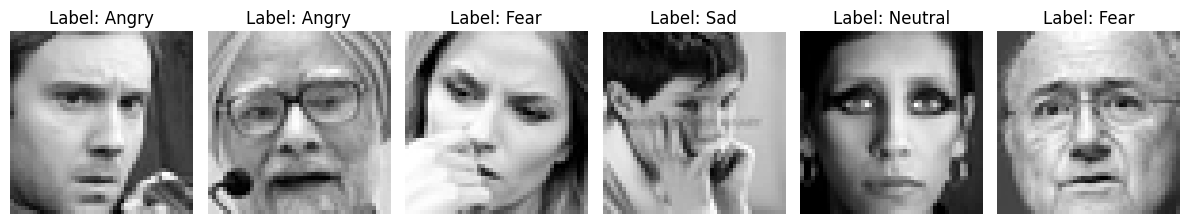

In [16]:
import matplotlib.pyplot as plt

def show_images(images, labels, classes, num_images=6):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {classes[labels[i].item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Define emotion classes
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Display the first few images and labels
show_images(train_X[:6], train_y[:6], classes)

Epoch 1, Train Loss: 1.642321161013138, Val Loss: 1.5333329291470283
Epoch 2, Train Loss: 1.4417304926300898, Val Loss: 1.3902538223604186
Epoch 3, Train Loss: 1.331418388404931, Val Loss: 1.3255871587095007
Epoch 4, Train Loss: 1.24581085839091, Val Loss: 1.2753407607036353
Epoch 5, Train Loss: 1.174020426177766, Val Loss: 1.262104508096138
Epoch 6, Train Loss: 1.1085759166354325, Val Loss: 1.2545913726882596
Epoch 7, Train Loss: 1.0426466892450583, Val Loss: 1.2506248671396645
Epoch 8, Train Loss: 0.9742057444258098, Val Loss: 1.268686809371003
Epoch 9, Train Loss: 0.9125374094946082, Val Loss: 1.2895924285449814
Epoch 10, Train Loss: 0.8446703891711671, Val Loss: 1.3113709434998775


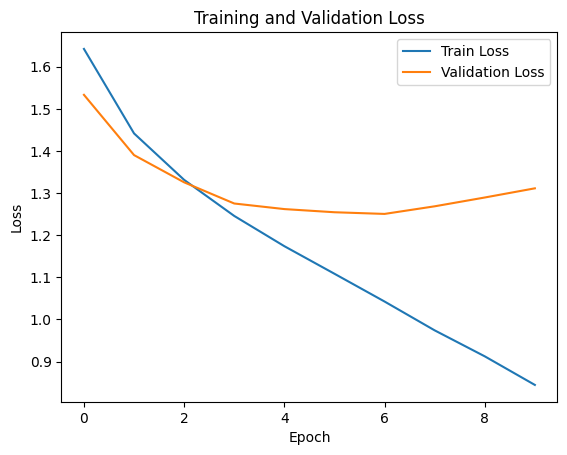

In [17]:
# Initialize lists to store loss values
train_losses = []
val_losses = []

# Modify the training loop to log losses
for epoch in range(10):
    running_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(test_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")

# Plot training and validation loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

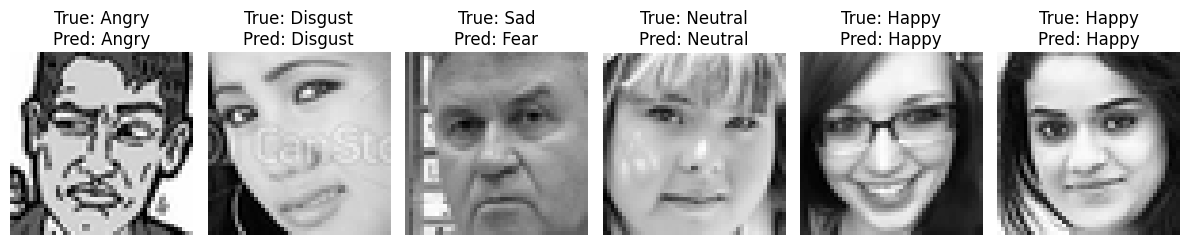

In [18]:
def show_predictions(images, labels, predictions, classes, num_images=6):
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True: {classes[labels[i].item()]}\nPred: {classes[predictions[i].item()]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate predictions for some test images
model.eval()
with torch.no_grad():
    sample_images = test_X[:6]
    sample_labels = test_y[:6]
    outputs = model(sample_images)
    _, preds = torch.max(outputs, 1)

# Show predictions
show_predictions(sample_images, sample_labels, preds, classes)

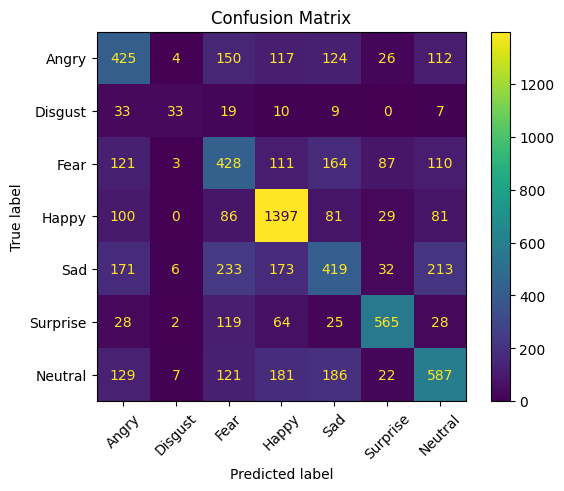

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the entire test set
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()